In [1]:
import os
from IPython.display import clear_output


notebook_dir = "/home/balabaevvl/courses/project/FITS/src/"
os.chdir(notebook_dir)

GPUs = [
    "GPU-e83bd31b-fcb9-b8de-f617-2d717619413b",
    "GPU-5a9b7750-9f85-49a5-3aae-fe07b1b7661d",
    "GPU-fe2d8dfd-06f2-a5c4-a7fd-4a5f23947005",
    "GPU-0c320096-21ee-4060-8731-826ca2febfab",
    "GPU-baef952c-6609-aace-3b78-e4e07788d5de",
    "GPU-3979d65b-c238-4e9c-0c1c-1aa3f05c56a1",
    "GPU-6c76a2c5-5375-aa06-11d4-0fddfac30e91",
]
os.environ["CUDA_VISIBLE_DEVICES"] = f"{GPUs[2]}"

In [2]:
import torch
from fits.modelling.framework import Train, Evaluate
from fits.dataframes.dataset import DatasetSolar
from fits.dataframes.dataloader import ForecastingDataLoader
from fits.modelling.comparison import (
    CalculateParams,
    LoadBestModel,
    ReadMetrics,
    VisualizeForecastSample,
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NSAMPLE = 5

In [3]:
from fits.dataframes.download import DownloadDatasetSolar

DownloadDatasetSolar()

# VAR

In [4]:
from fits.modelling.VAR.model import SeasonalVAR, VARConfig


In [ ]:
train_loader, valid_loader, test_loader = ForecastingDataLoader(
    DatasetSolar,
    batch_size=1024,
    n_features=64,
)  # shape=[B, L=96, K=64], horizon=24
normalization_stats = train_loader.dataset.normalization_stats

In [5]:
model_name = "var_solar"


In [ ]:
var = SeasonalVAR(VARConfig(feature_size=64, lag_order=60, seasonal_period=48)).to(device)
print(f"Total params: {CalculateParams(var)}")

In [ ]:
Train(
    var,
    train_loader,
    valid_loader,
    epochs=75,
    valid_epoch_interval=5,
    warmup_epochs=0,
    folder_name=model_name,
)

In [ ]:
LoadBestModel(var, model_name, device)
clear_output()


In [ ]:
Evaluate(
    var,
    test_loader,
    normalization_stats,
    nsample=NSAMPLE,
    folder_name=model_name,
)

In [6]:
ReadMetrics(model_name, nsample=NSAMPLE)
# VisualizeForecastSample(model_name, nsample=NSAMPLE, sample_index=10)

RMSE: 4.175950717331145
MAE: 2.7598925954927274
CRPS: 0.7547754488493267
CRPS_sum: 0.6526513852571186


{'rmse': 4.175950717331145,
 'mae': 2.7598925954927274,
 'crps': 0.7547754488493267,
 'crps_sum': 0.6526513852571186}

In [ ]:
import gc, torch

del var
gc.collect()
torch.cuda.empty_cache()

# CSDI

In [ ]:
from fits.modelling.CSDI.adapter import CSDIAdapter, CSDIConfig, CSDIDiffusionConfig


In [ ]:
train_loader, valid_loader, test_loader = ForecastingDataLoader(
    DatasetSolar,
    batch_size=64,
    n_features=64,
)  # shape=[B, L=96, K=64], horizon=24
normalization_stats = train_loader.dataset.normalization_stats


In [ ]:
model_name = "csdi_solar"

csdi = CSDIAdapter(
    CSDIConfig(
        target_dim=64,
        num_sample_features=64,
        diffusion=CSDIDiffusionConfig(
            layers=3,
            channels=48,
            nheads=6,
        ),
    )
).to(device)
print(f"Total params: {CalculateParams(csdi)}")

In [ ]:
Train(
    csdi,
    train_loader,
    valid_loader,
    epochs=100,
    valid_epoch_interval=5,
    warmup_epochs=0,
    folder_name=model_name,
)

In [ ]:
LoadBestModel(csdi, model_name, device)
clear_output()


In [ ]:
Evaluate(
    csdi,
    test_loader,
    normalization_stats,
    nsample=NSAMPLE,
    folder_name=model_name,
)

In [ ]:
ReadMetrics(model_name, nsample=NSAMPLE)
# VisualizeForecastSample(model_name, nsample=NSAMPLE, sample_index=10)

In [ ]:
import gc, torch

del csdi
gc.collect()
torch.cuda.empty_cache()

# DiffusionTS

In [ ]:
from fits.modelling.DiffusionTS.adapter import DiffusionTSAdapter, DiffusionTSConfig


In [ ]:
train_loader, valid_loader, test_loader = ForecastingDataLoader(
    DatasetSolar,
    batch_size=1024,
    n_features=64,
)  # shape=[B, L=96, K=64], horizon=24
normalization_stats = train_loader.dataset.normalization_stats


In [7]:
model_name = "diffusionts_solar"


In [ ]:
diffusionts = DiffusionTSAdapter(
    DiffusionTSConfig(
        seq_len=96,
        feature_size=64,
        timesteps=500,
        sampling_timesteps=200,
    )
).to(device)
print(f"Total params: {CalculateParams(diffusionts)}")


In [ ]:
Train(
    diffusionts,
    train_loader,
    valid_loader,
    epochs=300,
    valid_epoch_interval=10,
    weight_decay=0,
    warmup_epochs=0,
    folder_name=model_name,
)


In [ ]:
LoadBestModel(diffusionts, model_name, device)
clear_output()


In [ ]:
Evaluate(
    diffusionts,
    test_loader,
    normalization_stats,
    nsample=NSAMPLE,
    folder_name=model_name,
)


In [8]:
ReadMetrics(model_name, nsample=NSAMPLE)
# VisualizeForecastSample(model_name, nsample=NSAMPLE, sample_index=10)


RMSE: 6.94583250651694
MAE: 3.263890150116711
CRPS: 0.7420264294272975
CRPS_sum: 0.6818254370438425


{'rmse': 6.94583250651694,
 'mae': 3.263890150116711,
 'crps': 0.7420264294272975,
 'crps_sum': 0.6818254370438425}

# FM-TS

In [ ]:
from fits.modelling.FMTS.adapter import FMTSAdapter, FMTSConfig


In [ ]:
train_loader, valid_loader, test_loader = ForecastingDataLoader(
    DatasetSolar,
    batch_size=1024,
    n_features=64,
)  # shape=[B, L=96, K=64], horizon=24
normalization_stats = train_loader.dataset.normalization_stats

In [9]:
model_name = "fmts_solar"


In [ ]:
fmts = FMTSAdapter(
    FMTSConfig(
        seq_len=96,
        feature_size=64,
        n_layer_enc=3,
        n_layer_dec=3,
    )
).to(device)
print(f"Total params: {CalculateParams(fmts)}")

In [ ]:
Train(
    fmts,
    train_loader,
    valid_loader,
    epochs=500,
    valid_epoch_interval=10,
    weight_decay=0,
    warmup_epochs=0,
    grad_clip_norm=0.1,
    folder_name=model_name,
)

In [ ]:
LoadBestModel(fmts, model_name, device)
clear_output()


In [ ]:
Evaluate(
    fmts,
    test_loader,
    normalization_stats,
    nsample=NSAMPLE,
    folder_name=model_name,
)

In [10]:
ReadMetrics(model_name, nsample=NSAMPLE)
# VisualizeForecastSample(model_name, nsample=NSAMPLE, sample_index=10)

RMSE: 7.172500517937558
MAE: 5.5339092471735265
CRPS: 1.343178196957237
CRPS_sum: 1.4041948820415295


{'rmse': 7.172500517937558,
 'mae': 5.5339092471735265,
 'crps': 1.343178196957237,
 'crps_sum': 1.4041948820415295}

In [ ]:
import gc, torch

del fmts
gc.collect()
torch.cuda.empty_cache()

# FITS

In [11]:
from fits.modelling.FITS.model import FITSModel, FITSConfig


In [12]:
train_loader, valid_loader, test_loader = ForecastingDataLoader(
    DatasetSolar,
    batch_size=1024,
    n_features=64,
)  # shape=[B, L=96, K=64], horizon=24
normalization_stats = train_loader.dataset.normalization_stats

### first_differences

In [13]:
model_name = "fits_solar_first_differences"


fits = FITSModel(FITSConfig(
        seq_len=96,
        feature_size=64,
        n_layer_enc=3,
        n_layer_dec=3,
        first_differences=True,
        conditional=False,
)).to(device)
print(f"Total params: {CalculateParams(fits)}")

Total params: 676588


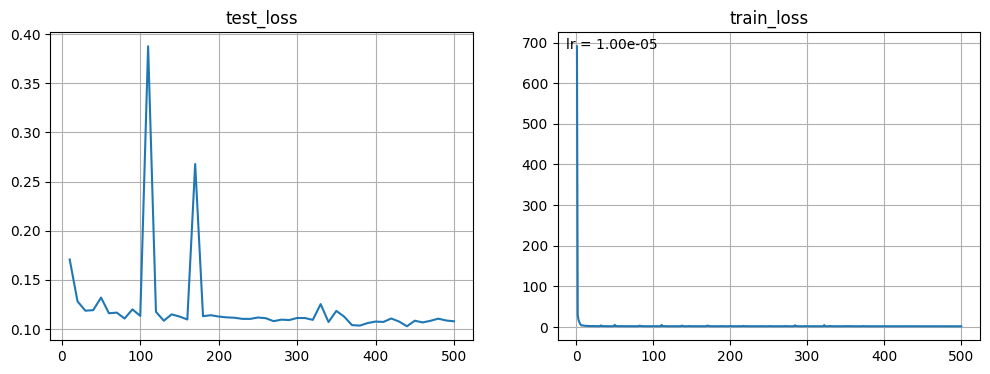

In [14]:
Train(
    fits,
    train_loader,
    valid_loader,
    epochs=500,
    valid_epoch_interval=10,
    weight_decay=0,
    warmup_epochs=0,
    grad_clip_norm=0.1,
    folder_name=model_name,
)

In [15]:
LoadBestModel(fits, model_name, device)
clear_output()


In [16]:
Evaluate(
    fits,
    test_loader,
    normalization_stats,
    nsample=NSAMPLE,
    folder_name=model_name,
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [14:59<00:00, 299.80s/it, rmse_total=5.88, mae_total=3.5, batch_no=3]


RMSE: 5.8836095202456375
MAE: 3.5029047524056782
CRPS: 0.9123144651714125
CRPS_sum: 0.8025430880094829


In [17]:
ReadMetrics(model_name, nsample=NSAMPLE)
# VisualizeForecastSample(model_name, nsample=NSAMPLE, sample_index=10)


RMSE: 5.8836095202456375
MAE: 3.5029047524056782
CRPS: 0.9123144651714125
CRPS_sum: 0.8025430880094829


{'rmse': 5.8836095202456375,
 'mae': 3.5029047524056782,
 'crps': 0.9123144651714125,
 'crps_sum': 0.8025430880094829}

### conditional

In [18]:
model_name = "fits_solar_conditional"


fits = FITSModel(FITSConfig(
        seq_len=96,
        feature_size=64,
        n_layer_enc=3,
        n_layer_dec=3,
        first_differences=False,
        conditional=True,
)).to(device)
print(f"Total params: {CalculateParams(fits)}")

Total params: 676588


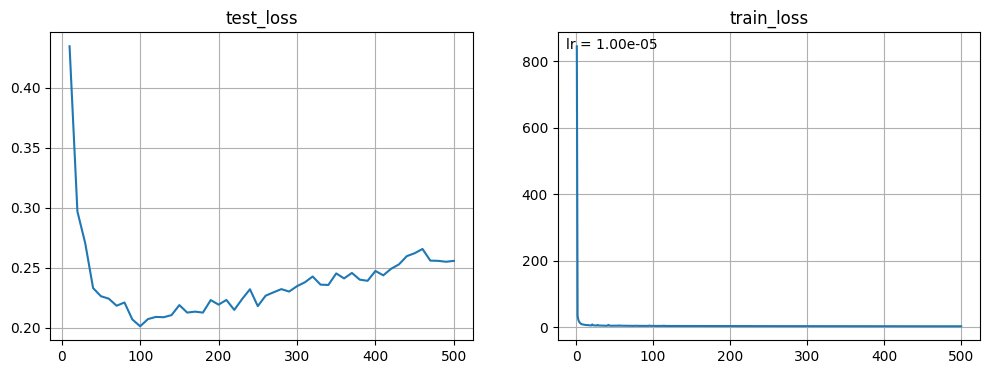

In [19]:
Train(
    fits,
    train_loader,
    valid_loader,
    epochs=500,
    valid_epoch_interval=10,
    weight_decay=0,
    warmup_epochs=0,
    grad_clip_norm=0.1,
    folder_name=model_name,
)

In [20]:
LoadBestModel(fits, model_name, device)
clear_output()


In [21]:
Evaluate(
    fits,
    test_loader,
    normalization_stats,
    nsample=NSAMPLE,
    folder_name=model_name,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [15:11<00:00, 303.79s/it, rmse_total=5.92, mae_total=2.83, batch_no=3]


RMSE: 5.916886872771896
MAE: 2.834007511293985
CRPS: 0.6869240810996607
CRPS_sum: 0.5453521828902396


In [22]:
ReadMetrics(model_name, nsample=NSAMPLE)
# VisualizeForecastSample(model_name, nsample=NSAMPLE, sample_index=10)


RMSE: 5.916886872771896
MAE: 2.834007511293985
CRPS: 0.6869240810996607
CRPS_sum: 0.5453521828902396


{'rmse': 5.916886872771896,
 'mae': 2.834007511293985,
 'crps': 0.6869240810996607,
 'crps_sum': 0.5453521828902396}

### first_differences & conditional

In [23]:
model_name = "fits_solar_both"


fits = FITSModel(FITSConfig(
        seq_len=96,
        feature_size=64,
        n_layer_enc=3,
        n_layer_dec=3,
        first_differences=True,
        conditional=True,
)).to(device)
print(f"Total params: {CalculateParams(fits)}")

Total params: 676588


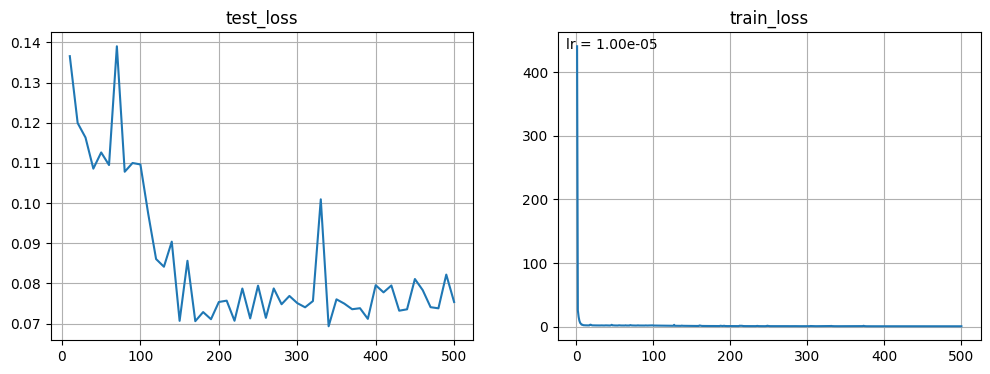

In [ ]:
Train(
    fits,
    train_loader,
    valid_loader,
    epochs=500,
    valid_epoch_interval=10,
    weight_decay=0,
    warmup_epochs=0,
    grad_clip_norm=0.1,
    folder_name=model_name,
)

In [25]:
LoadBestModel(fits, model_name, device)
clear_output()


In [26]:
Evaluate(
    fits,
    test_loader,
    normalization_stats,
    nsample=NSAMPLE,
    folder_name=model_name,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [15:11<00:00, 303.95s/it, rmse_total=5.26, mae_total=2.97, batch_no=3]


RMSE: 5.25966924414754
MAE: 2.9734807208301577
CRPS: 0.7667970657348633
CRPS_sum: 0.5088638004503752


In [27]:
ReadMetrics(model_name, nsample=NSAMPLE)
# VisualizeForecastSample(model_name, nsample=NSAMPLE, sample_index=10)

# RMSE: 8.691645741045287
# MAE: 3.71538814484127
# CRPS: 1.1622927816290605
# CRPS_sum: 0.8711835961592825

RMSE: 5.25966924414754
MAE: 2.9734807208301577
CRPS: 0.7667970657348633
CRPS_sum: 0.5088638004503752


{'rmse': 5.25966924414754,
 'mae': 2.9734807208301577,
 'crps': 0.7667970657348633,
 'crps_sum': 0.5088638004503752}

# FITSJ

In [28]:
from fits.modelling.FITSJ.model import FITSModel, FITSConfig


In [29]:
train_loader, valid_loader, test_loader = ForecastingDataLoader(
    DatasetSolar,
    batch_size=1024,
    n_features=64,
)  # shape=[B, L=96, K=64], horizon=24
normalization_stats = train_loader.dataset.normalization_stats

In [30]:
model_name = "fitsj_solar"


fits = FITSModel(FITSConfig(
        seq_len=96,
        feature_size=64,
        n_layer_enc=3,
        n_layer_dec=3,
        first_differences=True,
        conditional=True,
)).to(device)
print(f"Total params: {CalculateParams(fits)}")

Total params: 676588


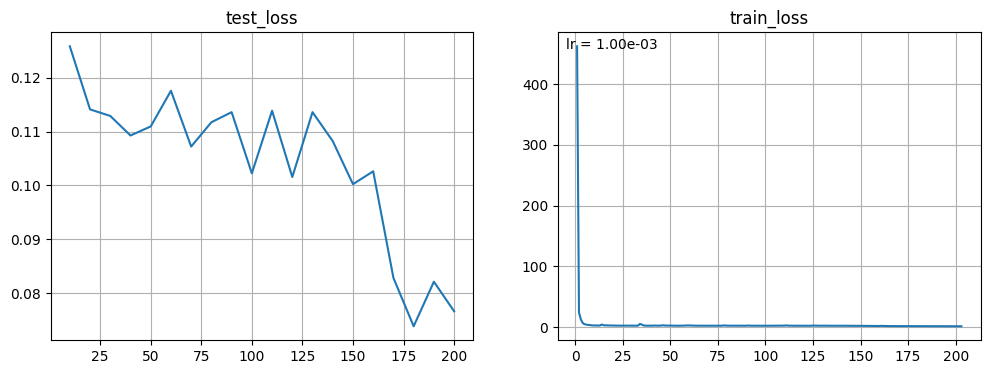

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:24<00:00,  1.90it/s, avg_epoch_loss=0.0251, epoch=203]


In [ ]:
Train(
    fits,
    train_loader,
    valid_loader,
    epochs=500,
    valid_epoch_interval=10,
    weight_decay=0,
    warmup_epochs=0,
    grad_clip_norm=0.1,
    folder_name=model_name,
)

In [ ]:
LoadBestModel(fits, model_name, device)
clear_output()


In [ ]:
Evaluate(
    fits,
    test_loader,
    normalization_stats,
    nsample=NSAMPLE,
    folder_name=model_name,
)

In [ ]:
ReadMetrics(model_name, nsample=NSAMPLE)
# VisualizeForecastSample(model_name, nsample=NSAMPLE, sample_index=10)
